# Import Packages

In [1]:
# built-in
from collections import Counter
import itertools
import os.path
import re

# third-party (pip install required)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
from pymodulon.compare import compare_ica
from pymodulon.io import load_json_model
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

# set matplotlib params
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

# Load Data

In [2]:
PRECISE_PATH = '../../data/precise/'
P1K_PATH = '../../data/precise1k/'
FIG_PATH = 'summarize_imodulons_figs'
ANNOTATION_PATH = '../../data/annotation/'

In [72]:
ica_data = load_json_model(os.path.join(P1K_PATH, 'precise1k.json.gz'))
imod_table = ica_data.imodulon_table
log_tpm = pd.read_csv(os.path.join(P1K_PATH, 'log_tpm_qc.csv'), index_col=0)

# Category Breakdowns

## bar_and_pie Function

In [15]:
def bar_and_pie(category, figsize=(6, 2.5), colors=None, im_table=imod_table):
    imod_cat_counts = Counter(im_table[category])
    sorted_cats, sorted_counts = zip(*sorted(list(imod_cat_counts.items()), key=lambda tup: tup[1], reverse=True))
    if colors is not None:
        color_dict = dict(zip(sorted_cats, colors))
    else:
        color_dict = dict(zip(sorted_cats, [pylab.get_cmap('tab10')(i/(len(sorted_cats))) for i in range(0,len(sorted_cats))]))
    color_dict['Unexplained'] = 'gray'
    print(sorted_cats)
    
    fig, (ax_bar, ax_pie_var) = plt.subplots(1, 2, figsize=figsize)

    bar_range = -1 * np.arange(0, len(sorted_cats))
    ax_bar.barh(bar_range, sorted_counts, tick_label=sorted_cats, color=[color_dict[cat] for cat in sorted_cats])
    ax_bar.set_xlabel('# of iModulons', fontsize=10)
    ax_bar.tick_params(axis='both', labelsize=10)
    if len(sorted_counts) < 20:
        for height, count in zip(bar_range, sorted_counts):
            ax_bar.text(count+1, height, count, fontsize=10, va='center')
        ax_bar.set_xlim(right=sorted_counts[0] + 15)
    for i in ax_bar.spines.values():
        i.set_linewidth(0.6)
    ax_bar.grid(visible=True, axis='x', linewidth=0.5)
    
    exp_vars = []
    exp_var_tot = im_table['exp_var'].sum()
    # manually add in the "unexplained" category
    for cat in sorted_cats:
        exp_var = im_table[im_table[category] == cat]['exp_var'].sum()
        exp_vars.append(exp_var)
    sorted_vars, sorted_cats_var = zip(*sorted(zip(exp_vars, sorted_cats), key=lambda tup: tup[0], reverse=True))

    # make unexplained last
    unexp_var = 1 - im_table['exp_var'].sum()
    sorted_vars = list(sorted_vars)
    sorted_vars.append(unexp_var)
    sorted_cats_var = list(sorted_cats_var)
    sorted_cats_var.append('Unexplained')

    
    pie_labels_var = []
    for cat, var in zip(sorted_cats_var, sorted_vars):
        if var < 0.045 and len(sorted_cats_var) > 4:
            pie_labels_var.append('')
        else:
            pie_labels_var.append(f'{max(int(np.round(var*100, decimals=0)), 1)}%')

    ax_pie_var.pie(sorted_vars, labels=pie_labels_var, colors=[color_dict[cat] for cat in sorted_cats_var],
              labeldistance=1.1, textprops={'fontsize': 9, 'ha': 'center'}, wedgeprops={'edgecolor': 'k', 'linewidth': 0.5})
    ax_pie_var.set_title('Total Variance', fontsize=11)
    
    plt.tight_layout()
    
    return fig

## Enrichment Category

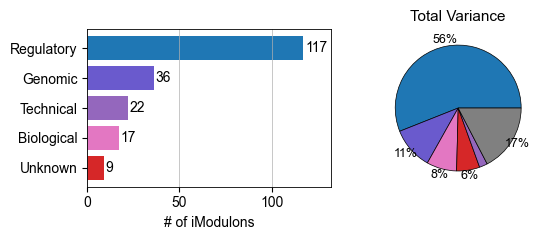

In [7]:
fig_enrich = bar_and_pie('enrichment_category', colors=['tab:blue', 'slateblue', 'tab:purple', 'tab:pink', 'tab:red'], figsize=(6, 2.5))
plt.savefig(os.path.join(FIG_PATH, 'iM_summary_enrichment.svg'), bbox_inches='tight', dpi=400)
plt.savefig(os.path.join(FIG_PATH, 'iM_summary_enrichment.png'), bbox_inches='tight', dpi=400)

## System Category

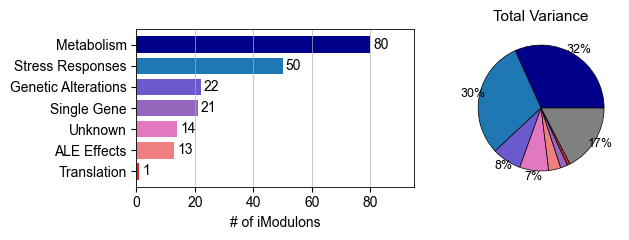

In [8]:
fig_system = bar_and_pie('system_category', figsize=(7, 2.5), colors=['darkblue', 'tab:blue', 'slateblue', 'tab:purple', 'tab:pink', 'lightcoral', 'tab:red'])
plt.savefig(os.path.join(FIG_PATH, 'iM_summary_system.svg'), bbox_inches='tight', dpi=400)
plt.savefig(os.path.join(FIG_PATH, 'iM_summary_system.png'), bbox_inches='tight', dpi=400)

## Functional Category

In [16]:
# combine some low-exp-var categories so there aren't too many colors in this plot
func_cat_to_var = {}
for func_cat, func_cat_df in imod_table.groupby('functional_category'):
    func_cat_to_var[func_cat] = func_cat_df['exp_var'].sum()
sorted_cat_to_var = sorted(list(func_cat_to_var.items()), key=lambda tup: tup[1], reverse=True)

n_max = 12
other_cats = [tup[0] for tup in sorted_cat_to_var[n_max:]]
func_im_table = imod_table.copy()
func_im_table = func_im_table.assign(functional_category=func_im_table['functional_category'].apply(lambda cat: 'Other' if cat in other_cats else cat))

('Unknown', 'Carbon Metabolism', 'Other', 'Energy Metabolism', 'Amino Acid Metabolism', 'Metal Homeostasis', 'Extracellular Structures', 'Envelope Stress', 'Nitrogen Metabolism', 'Temperature Shock', 'Nucleotide Metabolism', 'Global Stress', 'Genome Reduction')


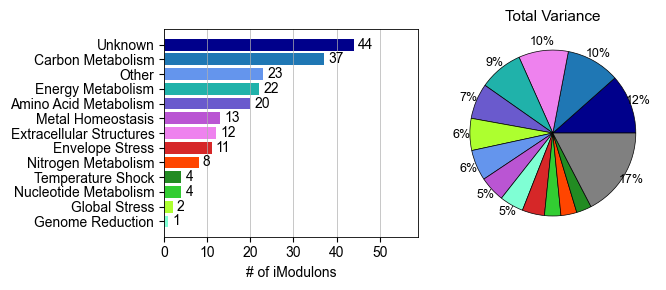

In [32]:
func_cols = ['darkblue', 'tab:blue', 'cornflowerblue', 'lightseagreen',
                                'slateblue', 'mediumorchid', 'violet', 'tab:red',
                                 'orangered', 'forestgreen', 'limegreen', 'greenyellow', 'aquamarine']
fig_func = bar_and_pie('functional_category', figsize=(7, 3), colors=func_cols, im_table=func_im_table)
plt.savefig(os.path.join(FIG_PATH, 'iM_summary_function.svg'), bbox_inches='tight', dpi=400)
plt.savefig(os.path.join(FIG_PATH, 'iM_summary_function.png'), bbox_inches='tight', dpi=400)

# High Variance iMs

/var/folders/ts/jx8__t2j39bdz86p320tyc5w0000gn/T/ipykernel_90049/4126822967.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(list(sorted_imod_table.index)[:n_top])), rotation=0, fontsize=10, ha='right')


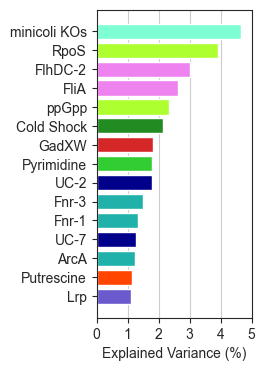

In [33]:
sns.set_style('ticks')
sorted_imod_table = func_im_table.sort_values(by='exp_var', ascending=False)
imod_cat_counts = Counter(func_im_table['functional_category'])
sorted_cats, sorted_counts = zip(*sorted(list(imod_cat_counts.items()), key=lambda tup: tup[1], reverse=True))
color_dict = dict(zip(sorted_cats, func_cols))

_, ax = plt.subplots(figsize=(2, 4))
n_top = 15
for i, im_row in enumerate(sorted_imod_table.itertuples()):

    if i < n_top:
        ax.barh(0-i, im_row.exp_var*100, color=color_dict[im_row.functional_category])
        
ax.set_xlabel('Explained Variance (%)')
ax.set_yticklabels(list(reversed(list(sorted_imod_table.index)[:n_top])), rotation=0, fontsize=10, ha='right')
ax.set_yticks(range(-n_top+1, 1))
ax.set_xticks(range(6))
ax.xaxis.grid(True)
for i in ax.spines.values():
    i.set_linewidth(0.8)
plt.savefig(os.path.join(FIG_PATH, 'high_variance_iMs.svg'), bbox_inches='tight', dpi=400)
plt.savefig(os.path.join(FIG_PATH, 'high_variance_iMs.png'), bbox_inches='tight', dpi=400)

# Regulatory Enrichment Statistics

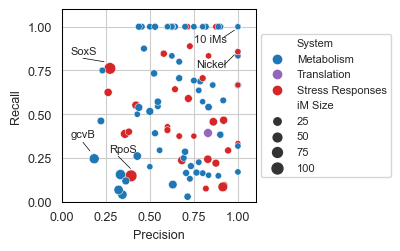

In [34]:
sns.set_style('whitegrid')

reg_im_table = ica_data.imodulon_table[ica_data.imodulon_table['enrichment_category'] == 'Regulatory'].copy()
reg_im_table = reg_im_table.rename(columns={'imodulon_size': 'iM Size', 'system_category': 'System'})

_, ax = plt.subplots(figsize=(2.5, 2.5))

sns.scatterplot(x='precision', y='recall', size='iM Size', data=reg_im_table, hue='System', palette=['tab:blue', 'tab:purple', 'tab:red'])

ax.set_xticks(np.arange(0, 1.1, 0.25))
ax.set_yticks(np.arange(0, 1.1, 0.25))
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.tick_params(axis='both', labelsize=9)

ax.plot((0.92, 0.98), (0.94, 0.98), linewidth=0.5, color='k')
ax.text(0.75, 0.9, '10 iMs', ha='left', va='bottom', fontsize=8, font='arial')

ax.plot((0.12, 0.24), (0.82, 0.80), linewidth=0.5, color='k')
ax.text(0.05, 0.83, 'SoxS', ha='left', va='bottom', fontsize=8, font='arial')

ax.plot((0.12, 0.16), (0.34, 0.29), linewidth=0.5, color='k')
ax.text(0.05, 0.36, 'gcvB', ha='left', va='bottom', fontsize=8, font='arial')

ax.plot((0.32, 0.39), (0.26, 0.19), linewidth=0.5, color='k')
ax.text(0.27, 0.27, 'RpoS', ha='left', va='bottom', fontsize=8, font='arial')

ax.plot((0.92, 0.98), (0.78, 0.84), linewidth=0.5, color='k')
ax.text(0.76, 0.76, 'Nickel', ha='left', va='bottom', fontsize=8, font='arial')

for s_loc, s in ax.spines.items():
    s.set_linewidth(0.75)
    s.set_color('k')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
ax.set_xlabel('Precision', fontsize=9)
ax.set_ylabel('Recall', fontsize=9)
plt.savefig(os.path.join(FIG_PATH, 'enrichment_stats.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'enrichment_stats.png'), dpi=400, bbox_inches='tight')

# RegulonDB Coverage

In [35]:
trn = pd.read_csv(os.path.join(ANNOTATION_PATH, 'TRN.csv'))

all_p1k_regs = []
all_p1k_reg_interacts = []
for _, imod_row in imod_table.iterrows():
    im_regs = imod_row['regulator']
    if pd.notna(im_regs):
        regs = re.split(f'/|\+', im_regs)
        all_p1k_regs.extend(regs)
        im_genes = ica_data.view_imodulon(imod_row.name).index
        all_p1k_reg_interacts.extend(list(itertools.product(regs, im_genes)))

all_p1k_regs = list(set(all_p1k_regs))
all_p1k_reg_interacts = list(set(all_p1k_reg_interacts))

# now annotate the trn with the info from imodulon table
trn = trn.assign(
    reg_in_ims=trn['regulator'].apply(lambda reg: reg in all_p1k_regs),
    interact_in_ims=trn.apply(lambda row: (row['regulator'], row['gene_id']) in all_p1k_reg_interacts, axis=1)
)

trn = trn[trn['regulator'] != 'RpoD']

by_reg = trn.groupby('regulator').sum()
by_reg = by_reg.assign(
    evidence=by_reg.evidence.apply(lambda ev: 'Weak' if ev == 0 else 'Strong'),
    reg_in_ims=by_reg.reg_in_ims.apply(lambda in_im: in_im != 0),
    n_interact=trn.groupby('regulator').count().get('gene_name')
)

/var/folders/ts/jx8__t2j39bdz86p320tyc5w0000gn/T/ipykernel_90049/3169309551.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_reg = trn.groupby('regulator').sum()


In [36]:
n_strong_in_im = by_reg[(by_reg['evidence'] == 'Strong') & (by_reg['reg_in_ims'])].shape[0]
n_strong_total = by_reg[(by_reg['evidence'] == 'Strong')].shape[0]

print(f'{n_strong_in_im}/{n_strong_total} ({n_strong_in_im/n_strong_total*100:.0f}%) regulators with some strong evidence in iModulons')

all_in_im = by_reg[by_reg['reg_in_ims']].shape[0]
all_total = by_reg.shape[0]
print(f'{all_in_im}/{all_total} ({all_in_im/all_total*100:.0f}%) regulators in iModulons')

n_strong_interact_in_im = trn[(trn['evidence'] > 0) & (trn['interact_in_ims'])].shape[0]
n_strong_interact_w_reg_in_im = trn[(trn['evidence'] > 0) & (trn['reg_in_ims'])].shape[0]
n_strong_interact = trn[(trn['evidence'] > 0)].shape[0]

print(f'{n_strong_interact_in_im}/{n_strong_interact} ({n_strong_interact_in_im/n_strong_interact*100:.0f}%) strong evidence interactions in iModulons',
      f'({n_strong_interact_w_reg_in_im} [{n_strong_interact_w_reg_in_im/n_strong_interact*100:.0f}%] strong interactions have regulator in iModulon)')

all_interact_in_im = trn[trn['interact_in_ims']].shape[0]
n_interact_w_reg_in_im = trn[trn['reg_in_ims']].shape[0]
all_interact_total = trn.shape[0]

print(f'{all_interact_in_im}/{all_interact_total} ({all_interact_in_im/all_interact_total*100:.0f}%) interactions in iModulons',
      f'({n_interact_w_reg_in_im} [{n_interact_w_reg_in_im/all_interact_total*100:.0f}%] interactions have regulator in iModulon)')

91/190 (48%) regulators with some strong evidence in iModulons
120/370 (32%) regulators in iModulons
1130/3417 (33%) strong evidence interactions in iModulons (2948 [86%] strong interactions have regulator in iModulon)
2100/9092 (23%) interactions in iModulons (7230 [80%] interactions have regulator in iModulon)


## Number of Regulators/Interactions

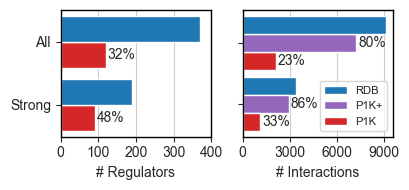

In [39]:
sns.set_style('ticks')
fig, (ax_tfs, ax_ris) = plt.subplots(1, 2, figsize=(4.2, 2))

ax_tfs.barh(0.125, n_strong_in_im, height=0.25, color='tab:red')
ax_tfs.barh(0.375, n_strong_total, height=0.25, color='tab:blue')
ax_tfs.text(n_strong_in_im + 5, 0.125, f'{n_strong_in_im/n_strong_total*100:.0f}%', va='center')
ax_tfs.barh(0.725, all_in_im, height=0.25, color='tab:red')
ax_tfs.barh(0.975, all_total, height=0.25, color='tab:blue')
ax_tfs.text(all_in_im + 5, 0.725, f'{all_in_im/all_total*100:.0f}%', va='center')
for s in ax_tfs.spines.values():
    s.set_linewidth(1)
    s.set_color('black')
ax_tfs.set_xlabel('# Regulators')
ax_tfs.set_yticks([0.25, 0.85])
ax_tfs.set_yticklabels(['Strong', 'All'])
ax_tfs.set_xticks(np.arange(0, 500, 100))
ax_tfs.xaxis.grid(True)

ax_ris.barh(0.625, n_strong_interact, height=0.25, color='tab:blue', label='RDB')
ax_ris.barh(0.375, n_strong_interact_w_reg_in_im, height=0.25, color='tab:purple', label='P1K+')
ax_ris.barh(0.125, n_strong_interact_in_im, height=0.25, color='tab:red', label='P1K')
ax_ris.text(n_strong_interact_in_im + 100, 0.125, f'{n_strong_interact_in_im/n_strong_interact*100:.0f}%', va='center')
ax_ris.text(n_strong_interact_w_reg_in_im + 100, 0.375, f'{n_strong_interact_w_reg_in_im/n_strong_interact*100:.0f}%', va='center')
ax_ris.barh(0.975, all_interact_in_im, height=0.25, color='tab:red')
ax_ris.barh(1.225, n_interact_w_reg_in_im, height=0.25, color='tab:purple')
ax_ris.barh(1.475, all_interact_total, height=0.25, color='tab:blue')
ax_ris.text(all_interact_in_im + 100, 0.975, f'{all_interact_in_im/all_interact_total*100:.0f}%', va='center')
ax_ris.text(n_interact_w_reg_in_im + 100, 1.225, f'{n_interact_w_reg_in_im/all_interact_total*100:.0f}%', va='center')
for s in ax_ris.spines.values():
    s.set_linewidth(1)
    s.set_color('black')
ax_ris.set_xlabel('# Interactions')
ax_ris.legend(loc='lower right', fontsize=8)
ax_ris.set_yticks([0.375, 1.225])
ax_ris.set_yticklabels([])
ax_ris.set_xticks(np.arange(0, 12000, 3000))
ax_ris.xaxis.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(FIG_PATH, 'regulatory_coverage_bars.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'regulatory_coverage_bars.png'), dpi=400, bbox_inches='tight')

## Distribution of Regulon Sizes Covered

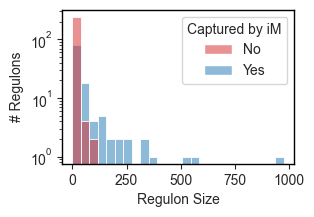

In [41]:
by_reg_fixed = by_reg.rename(columns={'reg_in_ims': 'in iM'})
by_reg_fixed = by_reg_fixed.rename(columns={'in iM': 'Captured by iM'})
by_reg_fixed['Captured by iM'] = by_reg_fixed['Captured by iM'].apply(lambda boole: 'Yes' if boole else 'No')

_, ax = plt.subplots(figsize=(3, 2))
sns.histplot(x='n_interact', hue='Captured by iM', palette=['tab:red','tab:blue'], data=by_reg_fixed, bins=25, alpha=0.5,ax=ax)
ax.set_yscale('log')
ax.set_ylabel('# Regulons')
ax.set_xlabel('Regulon Size')
ax.set_xticks(np.arange(0, 1250, 250))
for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1)

plt.savefig(os.path.join(FIG_PATH, 'covered_regulon_sizes.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'covered_regulon_sizes.png'), dpi=400, bbox_inches='tight')

# TCS iModulons

In [42]:
tcs_im_df = ica_data.imodulon_table[ica_data.imodulon_table['tcs'] == 'True']

In [43]:
pd.set_option('display.max_colwidth', 75)
to_display = tcs_im_df[['functional_category', 'function', 'regulator', 'exp_var']].sort_values(by='functional_category')
to_display['Explained Variance'] = np.round(to_display['exp_var'] * 100, decimals=1)
to_display = to_display.rename(columns={'functional_category': 'Category', 'function': 'Function'})
to_display.drop(columns=['exp_var'])

,Category,Function,regulator,Explained Variance
SCFA,Carbon Metabolism,Short-chain fatty acid (acetoacetate) transport and catabolism,RpoN+AtoC+IHF,0.0
Pyruvate-1,Carbon Metabolism,"Pyruvate sensing, transport, and catabolism under nutrient limitation",BtsR,0.2
Pyruvate-2,Carbon Metabolism,Pyruvate sensing and transport,PyrR,0.2
CpxR,Envelope Stress,Inner membrane damage sensing and repair via protein folding/degradatio...,CpxR,0.2
EvgA,Envelope Stress,"Glutamate-dependent acid response, drug resistance, alkali metals response",EvgA,0.2
BasR,Extracellular Structures,Lipid A modification and polymixin resistance in the presence of excess...,BasR,0.1
Magnesium,Metal Homeostasis,Magnesium sensing and transport; magnesium-limitation response,PhoP,0.1
Zinc-2,Metal Homeostasis,Tolerance to high zinc concentration,ZraR,0.1
Potassium,Metal Homeostasis,Potassium sensing and transport,KdpE,0.1
Copper,Metal Homeostasis,Copper/silver sensing and export,CusR/CueR/HprR,1.0


In [44]:
pd.set_option('display.max_colwidth', 50)

In [45]:
tcs_im_df.to_csv(os.path.join(FIG_PATH, 'tcs_im_table.csv'))

# M Matrix

Highlight Genes that Appear in Multiple iModulons

## Genes in Multiple iModulons

In [4]:
gene_im_df = pd.DataFrame(ica_data.M_binarized.sum(axis=1).sort_values(ascending=False), columns=['n_ims']).merge(
    ica_data.gene_table, how='left', left_index=True, right_index=True)

In [7]:
gene_im_df[gene_im_df['n_ims'] > 5]

,n_ims,gene_name,synonyms,gene_product,COG,regulator,uniprot,start,end,strand,...,y_ome,k_eff,schmidt_prot_med,heckmann_prot_med,proteomics,p1k,p1k_ctrl_log_tpm,p1k_median_log_tpm,p1k_mad_log_tpm,in_iM
b1596,7.0,ynfM,ynfM;yzyC,putative transporter YnfM,Amino acid transport and metabolism,YidZ,P43531,1669699,1670952,+,...,True,False,NaN,NaN,False,True,4.053018,4.160439,1.159962,True
b1112,7.0,bhsA,bhsA;comC;ycfR,DUF1471 domain-containing multiple stress resi...,Cell wall/membrane/envelope biogenesis,"RpoD,RpoE,Crp,ComR",P0AB40,1169073,1169330,+,...,False,False,384.5,NaN,True,True,6.943032,5.677704,1.538520,True
b1256,6.0,ompW,ompW;yciD,outer membrane protein W,Cell wall/membrane/envelope biogenesis,"rybB,ArcA,Crp,NarL,Fnr,SoxS,Fur,micA",P0A915,1314020,1314658,+,...,True,True,60.0,665.0,True,True,3.532991,4.617258,2.677211,True
b2943,6.0,galP,galP,galactose:H(+) symporter,Amino acid transport and metabolism,"RpoD,Crp,OmpR,NagC,GalR,GalS",P0AEP1,3088284,3089678,+,...,False,False,NaN,NaN,False,True,5.567029,5.553947,0.960139,True
b4735,6.0,ybgU,NaN,protein YbgU,No COG annotation,NaN,UPI0001A5C00D,754674,754781,-,...,False,False,NaN,NaN,False,True,9.400950,7.552668,2.219529,True
b4721,6.0,ytiD,NaN,protein YtiD,No COG annotation,"RpoD,ppGpp,DksA",UPI00000D0E23,4556654,4556797,+,...,True,False,NaN,NaN,False,True,2.998802,2.835838,1.655640,True
b3408,6.0,feoA,feoA,ferrous iron transport protein A,Inorganic ion transport and metabolism,"RpoD,Fur,Fnr,NagC,ArcA",P0AEL3,3540163,3540390,+,...,False,False,0.0,NaN,True,True,6.056112,7.301935,1.354488,True
b4662,6.0,sgrT,sgrT,putative inhibitor of the PtsG glucose transpo...,Energy production and conversion,"RpoD,RpoS,Cra,SgrR,ppGpp,DksA",C1P5Z7,77388,77519,+,...,True,False,NaN,NaN,False,True,4.960055,5.649277,1.465624,True


/var/folders/ts/jx8__t2j39bdz86p320tyc5w0000gn/T/ipykernel_47944/657904479.py:16: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 4000)


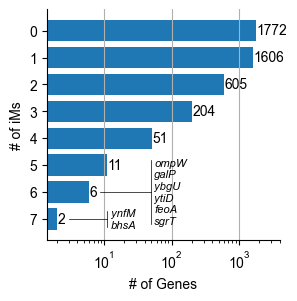

In [8]:
_, ax = plt.subplots(figsize=(3, 3))

plot_dict = {int(n_ims): n_im_df.shape[0] for n_ims, n_im_df in gene_im_df.groupby('n_ims')}

for n_ims, gene_count in plot_dict.items():
    ax.barh(len(plot_dict) - n_ims, gene_count, color='tab:blue')
    ax.text(gene_count * 1.02, len(plot_dict) - n_ims, gene_count, va='center')

for loc, s in ax.spines.items():
    if loc in ['top', 'right']:
        s.set_visible(False)
ax.set_yticks(range(1, 9))
ax.set_yticklabels(list(range(0, 8))[::-1])
ax.set_xscale('log')
ax.xaxis.grid()
ax.set_xlim(0, 4000)
ax.set_xlabel('# of Genes', fontsize=10)
ax.set_ylabel('# of iMs', fontsize=10)

ax.plot((3, 11), (1, 1), linewidth=0.5, color='k')
ax.plot((11, 11), (0.7, 1.3), linewidth=0.5, color='k')
ax.text(12.5, 1, 'ynfM\nbhsA', ha='left', va='center', fontsize=8, font='arial', fontstyle='italic')

ax.plot((8.8, 50), (2, 2), linewidth=0.5, color='k')
ax.plot((50, 50), (0.8, 3.2), linewidth=0.5, color='k')
ax.text(55, 2, 'ompW\ngalP\nybgU\nytiD\nfeoA\nsgrT', ha='left', va='center', fontsize=8, font='arial', fontstyle='italic')

plt.savefig(os.path.join(FIG_PATH, 'multi_im_genes.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'multi_im_genes.png'), dpi=400, bbox_inches='tight')

## iModulon Gene Counts

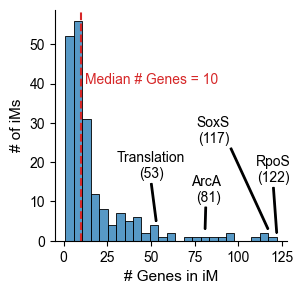

In [9]:
_, ax = plt.subplots(figsize=(3, 3))

sns.histplot(ica_data.imodulon_table['imodulon_size'], bins=25, ax=ax)

for s_loc, s in ax.spines.items():
    if s_loc in ['top', 'right']:
        s.set_visible(False)

med_size = ica_data.imodulon_table['imodulon_size'].median()
ax.axvline(med_size, linestyle='--', color='tab:red')
ax.text(med_size + 2, 40, f'Median # Genes = {int(med_size)}', color='tab:red')
        
ax.annotate('RpoS\n(122)', xy=(122, 2), xytext=(120, 15), arrowprops={'headwidth': 0, 'width': 1, 'headlength': 0.1}, ha='center')
ax.annotate('SoxS\n(117)', xy=(117, 3), xytext=(95, 25), arrowprops={'headwidth': 0, 'width': 1, 'headlength': 0.1}, ha='right')
ax.annotate('ArcA\n(81)', xy=(81, 3), xytext=(90, 10), arrowprops={'headwidth': 0, 'width': 1, 'headlength': 0.1}, ha='right')
ax.annotate('Translation\n(53)', xy=(53, 5), xytext=(50, 16), arrowprops={'headwidth': 0, 'width': 1, 'headlength': 0.1}, ha='center')

ax.set_xticks(range(0, 150, 25))
ax.set_xlabel('# Genes in iM', fontsize=11)
ax.set_ylabel('# of iMs', fontsize=11)

plt.savefig(os.path.join(FIG_PATH, 'im_sizes.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'im_sizes.png'), dpi=400, bbox_inches='tight')

## Binarized M

In [10]:
gene_order = ica_data.M_binarized.sum(axis=1).sort_values(ascending=False).index
im_order = ica_data.M_binarized.sum(axis=0).sort_values(ascending=False).index

M_sorted = ica_data.M.loc[gene_order][im_order]
M_binarized_sorted = ica_data.M_binarized.loc[gene_order][im_order]

2.52% of entries in top 50 genes/25 iMs


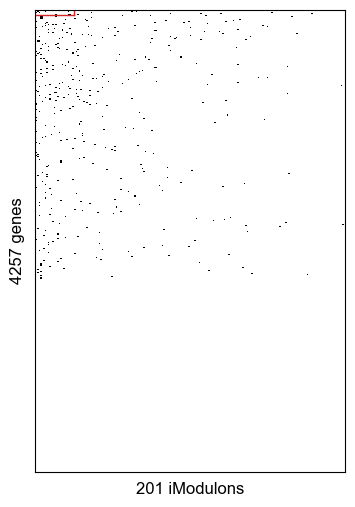

In [11]:
_, ax = plt.subplots(figsize=(4, 6))

sns.heatmap(M_binarized_sorted, xticklabels=False, yticklabels=False, cbar=False, cmap=['white', 'black'], ax=ax)

display_n_genes = 50
display_n_ims = 25

gene_zoom_frac = 1 - display_n_genes / M_binarized_sorted.shape[0]
imod_zoom_frac = display_n_ims / M_binarized_sorted.shape[1]

ax.plot((0, imod_zoom_frac), (gene_zoom_frac, gene_zoom_frac), transform=ax.transAxes, color='tab:red', linewidth=1)
ax.plot((imod_zoom_frac, imod_zoom_frac), (gene_zoom_frac, 1), transform=ax.transAxes, color='tab:red', linewidth=1)

total_ones = M_binarized_sorted.sum().sum()
display_slice = M_binarized_sorted.iloc[:display_n_genes, :display_n_ims]
display_slice.index = ica_data.gene_table.loc[display_slice.index]['gene_name']
display_ones = display_slice.sum().sum()

print(f'{display_ones/total_ones*100:.2f}% of entries in top {display_n_genes} genes/{display_n_ims} iMs')

for s in ax.spines.values():
    s.set_visible(True)

ax.set_xlabel('201 iModulons', fontsize=12)
ax.set_ylabel('4257 genes', fontsize=12)

plt.savefig(os.path.join(FIG_PATH, 'm_binary_full.png'), dpi=400, bbox_inches='tight')

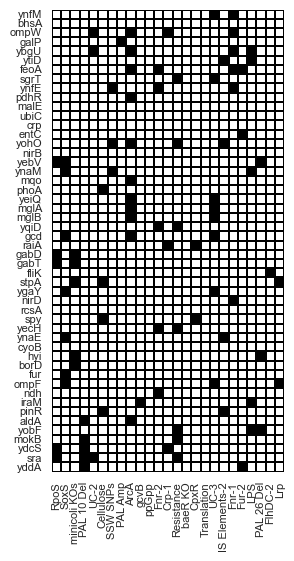

In [12]:
sns.set_style('whitegrid')

_, ax = plt.subplots(figsize=(3, 6))

sns.heatmap(display_slice, xticklabels=True, yticklabels=True, cbar=False, cmap=['white', 'black'], linewidths=0.003, linecolor='k', ax=ax)

ax.tick_params(axis='both', labelsize=8)
ax.set_ylabel('')

plt.savefig(os.path.join(FIG_PATH, 'm_binary_display.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'm_binary_display.png'), dpi=400, bbox_inches='tight')

## General Multi-iM Gene Study

### Compute Bootstrap Distributions

In [222]:
multi_im_gene_df = gene_im_df[gene_im_df['n_ims'] > 1]

# compute the A correlation matrix
A_matrix_corr = ica_data.A.T.corr(method='spearman').abs()

N_BOOTSTRAP = 1000

# compute bootstraps for median correlations between groups of genes of different sizes
n_genes_to_rand_corr_medians = {}
for n_genes in ica_data.imodulon_table['imodulon_size'].unique():
    if n_genes > 1:
        # now do a bootstrap test
        rand_medians = []
        for i in range(N_BOOTSTRAP):
            rand_log_tpm = log_tpm.sample(n=n_genes, random_state=i, replace=False)
            rand_gene_corr = rand_log_tpm.T.corr(method='spearman').abs()
            rand_gene_corr_mask = pd.DataFrame(np.triu(rand_gene_corr), index=rand_gene_corr.index, columns=rand_gene_corr.columns)
            rand_gene_corr_mask = rand_gene_corr_mask.replace(0, np.nan).replace(1, np.nan)
            rand_gene_corrs_w_na = rand_gene_corr_mask.values.flatten()
            rand_gene_corrs = rand_gene_corrs_w_na[~np.isnan(rand_gene_corrs_w_na)]
            rand_medians.append(np.median(rand_gene_corrs))
        n_genes_to_rand_corr_medians[n_genes] = rand_medians
        
# also do the same for iModulon activities
# do boostraps for the different numbers of iMs - can reuse the same null distribution for each iM size in principle
n_im_to_medians = {}
for n_ims in multi_im_gene_df['n_ims'].unique():
    rand_medians = []
    for i in range(N_BOOTSTRAP):
        rand_A = ica_data.A.sample(n=int(n_ims), random_state=i, replace=False)
        rand_A_corr = rand_A.T.corr(method='spearman').abs()
        rand_A_corr_mask = pd.DataFrame(np.triu(rand_A_corr), index=rand_A_corr.index, columns=rand_A_corr.columns)
        rand_A_corr_mask = rand_A_corr_mask.replace(0, np.nan).replace(1, np.nan)
        rand_A_corrs_w_na = rand_A_corr_mask.values.flatten()
        rand_A_corrs = rand_A_corrs_w_na[~np.isnan(rand_A_corrs_w_na)]
        rand_medians.append(np.median(rand_A_corrs))
    n_im_to_medians[n_ims] = rand_medians

In [241]:
# also compute the correlations bewteen genes each iM
im_to_gene_corr_df = {}

for im in ica_data.imodulon_names:
    
    im_genes = ica_data.view_imodulon(im).index
    if len(im_genes) == 1:
        continue
    
    im_gene_log_tpm = log_tpm.loc[im_genes]
    im_gene_corr = im_gene_log_tpm.T.corr(method='spearman').abs()
    im_to_gene_corr_df[im] = im_gene_corr
    im_gene_corr_mask = pd.DataFrame(np.triu(im_gene_corr), index=im_gene_corr.index, columns=im_gene_corr.columns)
    im_gene_corr_mask = im_gene_corr_mask.replace(0, np.nan).replace(1, np.nan)
    im_gene_corrs_w_na = im_gene_corr_mask.values.flatten()
    im_gene_corrs = im_gene_corrs_w_na[~np.isnan(im_gene_corrs_w_na)]
    median_im_corr = np.median(im_gene_corrs)

### Correlations within iMs

In [392]:
im_gene_corr_rows = []

for i, im in enumerate(ica_data.imodulon_names):
    print(f'{i+1}/201', end='\r')
    
    im_genes = ica_data.view_imodulon(im).index
    if len(im_genes) == 1:
        continue
    
    im_gene_corr = im_to_gene_corr_df[im]
    im_gene_corr_mask = pd.DataFrame(np.triu(im_gene_corr), index=im_gene_corr.index, columns=im_gene_corr.columns)
    im_gene_corr_mask = im_gene_corr_mask.replace(0, np.nan).replace(1, np.nan)
    im_gene_corrs_w_na = im_gene_corr_mask.values.flatten()
    im_gene_corrs = im_gene_corrs_w_na[~np.isnan(im_gene_corrs_w_na)]
    median_im_corr = np.median(im_gene_corrs)
    
    # get a P value - this is simply what percentage of the random ones are larger than the observed im one
    rand_medians = n_genes_to_rand_corr_medians[len(im_genes)]
    p = (np.array(rand_medians) > median_im_corr).sum() / N_BOOTSTRAP
    
    im_gene_corr_rows.append({
        'im_gene_median': median_im_corr,
        'rand_gene_median': np.median(rand_medians),
        'im': im,
        'n_genes': len(im_genes),
        'p': p
    })

all_im_corr_df = pd.DataFrame(im_gene_corr_rows)

_, adj_ps = fdrcorrection(all_im_corr_df['p'], alpha=0.05)
all_im_corr_df = all_im_corr_df.assign(
    p_adj=adj_ps
)
all_im_corr_df = all_im_corr_df.set_index('im')

im_table_with_corr_p = ica_data.imodulon_table.merge(all_im_corr_df, left_index=True, right_index=True, how='left')
im_table_with_corr_p = im_table_with_corr_p.assign(
    median_diff=(im_table_with_corr_p['im_gene_median'] - im_table_with_corr_p['rand_gene_median'])
)
im_table_with_corr_p = im_table_with_corr_p.sort_values(by='median_diff', ascending=False)

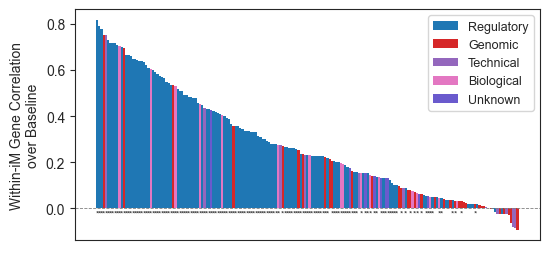

In [523]:
sns.set_style('ticks')

with_median_diff = im_table_with_corr_p[im_table_with_corr_p['median_diff'].notna()]

cat_to_col = {
    'Regulatory': 'tab:blue',
    'Genomic': 'tab:red',
    'Technical': 'tab:purple',
    'Biological': 'tab:pink',
    'Unknown': 'slateblue'
}
im_to_cat = dict(zip(with_median_diff.index, with_median_diff['enrichment_category']))

_, ax = plt.subplots(figsize=(6, 3))

for i, (im, med_diff_row) in enumerate(with_median_diff.iterrows()):
    
    im_cat = im_to_cat[im]
    ax.bar(i, med_diff_row['median_diff'], color=cat_to_col[im_cat], width=1, label=im_cat, lw=0)
    if med_diff_row['p_adj'] < 0.05:
        ax.text(i, (med_diff_row['median_diff'] / -med_diff_row['median_diff']) * 0.02, '*', fontsize=6, va='center', ha='center')

handles, labels = ax.get_legend_handles_labels()
new_handles = []
new_labels = []
for hand, lab in zip(handles, labels):
    if lab not in new_labels:
        new_handles.append(hand)
        new_labels.append(lab)
ax.legend(handles=new_handles, labels=new_labels, loc='upper right', fontsize=9)
ax.set_xticks([])
ax.axhline(0, linestyle='--', color='gray', lw=0.6)

ax.set_ylabel('Within-iM Gene Correlation\nover Baseline', fontsize=10)
plt.savefig(os.path.join(FIG_PATH, 'within_im_corrs.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'within_im_corrs.png'), dpi=400, bbox_inches='tight')

In [532]:
sig_pcts

Technical     13.636364
Unknown       88.888889
Biological    82.352941
Genomic       47.222222
Regulatory    88.034188
Name: enrichment_category, dtype: float64

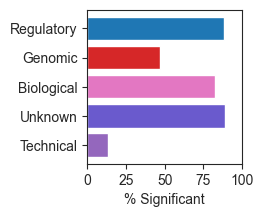

In [524]:
sig_cats = im_table_with_corr_p[im_table_with_corr_p['p_adj'] < 0.05]['enrichment_category'].value_counts()
sig_order = sig_cats.index
total_cats = im_table_with_corr_p['enrichment_category'].value_counts()
total_cats = total_cats.loc[sig_order]

sig_pcts = sig_cats / total_cats * 100
sig_pcts = sig_pcts[::-1]

_, ax = plt.subplots(figsize=(2, 2))

for i, (cat, pct) in enumerate(sig_pcts.items()):
    
    ax.barh(i, pct, label=cat, color=cat_to_col[cat])
    
ax.set_yticks(range(len(sig_pcts)))
ax.set_xlim(0, 100)
ax.set_yticklabels(sig_pcts.index)
ax.set_xlabel('% Significant')
ax.tick_params(axis='both', labelsize=10)
ax.set_xticks(range(0, 125, 25))

plt.savefig(os.path.join(FIG_PATH, 'pct_sig_im_corrs.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'pct_sig_im_corrs.png'), dpi=400, bbox_inches='tight')

### Correlations within iMs for Multi-iM Genes

In [451]:
multi_im_gene_corr_rows = []

for i, (gene_id, multi_im_gene_row) in enumerate(multi_im_gene_df.iterrows()):
    print(f'{i+1}/{multi_im_gene_df.shape[0]}', end='\r')
    
    gene_ims = ica_data.M.columns[ica_data.M_binarized.loc[gene_id] == 1].to_list()
    
    # get the correlations between the iM activities
    gene_im_A_corr = im_A_corr.loc[gene_ims, gene_ims]
    im_A_corr_mask = pd.DataFrame(np.triu(gene_im_A_corr), index=gene_im_A_corr.index, columns=gene_im_A_corr.columns)
    im_A_corr_mask = im_A_corr_mask.replace(0, np.nan).replace(1, np.nan)
    im_A_corr_w_na = im_A_corr_mask.values.flatten()
    im_A_corrs = im_A_corr_w_na[~np.isnan(im_A_corr_w_na)]
    median_gene_im_a_corr = np.median(im_A_corrs)
    
    # use the relevant null distribution here
    p = (np.array(n_im_to_medians[len(gene_ims)]) > median_gene_im_a_corr).sum() / N_BOOTSTRAP
    
    # we also want to see how correlated this gene is with each of its iM buddies
    
    multi_im_gene_corr_rows.append({
        'gene': gene_id,
        'n_ims': multi_im_gene_row['n_ims'],
        'median_im_A_corr': median_gene_im_a_corr,
        'p': p
    })
    
multi_im_gene_corr_df = pd.DataFrame(multi_im_gene_corr_rows)

_, adj_ps = fdrcorrection(multi_im_gene_corr_df['p'], alpha=0.05)
multi_im_gene_corr_df = multi_im_gene_corr_df.assign(
    p_adj=adj_ps
)
multi_im_gene_corr_df = multi_im_gene_corr_df.assign(
    im_set='True',
    sig=(multi_im_gene_corr_df['p_adj'] < 0.05)
)
multi_im_gene_corr_df = multi_im_gene_corr_df.set_index('gene')

/var/folders/ts/jx8__t2j39bdz86p320tyc5w0000gn/T/ipykernel_47944/606745210.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sig_data = multi_im_gene_corr_df.groupby('n_ims').sum()['sig'] / multi_im_gene_corr_df.groupby('n_ims').count()['sig']


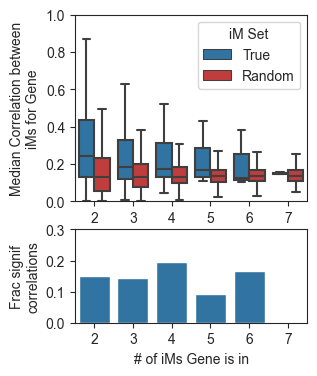

In [529]:
rand_im_corr_rows = []
for n_ims, rand_medians in n_im_to_medians.items():
    for rand_median in rand_medians:
        rand_im_corr_rows.append({
            'im_set': 'Random',
            'median_im_A_corr': rand_median,
            'n_ims': n_ims
        })
rand_im_corr_df = pd.DataFrame(rand_im_corr_rows)

combined_im_corr_df = pd.concat([multi_im_gene_corr_df, rand_im_corr_df])
combined_im_corr_df = combined_im_corr_df.rename(columns={'im_set': 'iM Set'})

_, (ax, ax_sig) = plt.subplots(2, 1, figsize=(3, 4), sharex=True, height_ratios=[2, 1])

sns.boxplot(y='median_im_A_corr', x='n_ims', data=combined_im_corr_df, ax=ax, hue='iM Set',
           hue_order=['True', 'Random'], palette=['tab:blue', 'tab:red'], showfliers=False)
ax.set_ylabel('Median Correlation between\niMs for Gene')
ax.set_ylim(0, 1)
ax.xaxis.set_tick_params(labelbottom=True)
ax.set_xlabel('')

sig_data = multi_im_gene_corr_df.groupby('n_ims').sum()['sig'] / multi_im_gene_corr_df.groupby('n_ims').count()['sig']

sns.barplot(x=sig_data.index, y=sig_data.values, ax=ax_sig, color='tab:blue')
ax_sig.set_ylim(0, 0.3)
ax_sig.set_ylabel('Frac signif\ncorrelations')
ax_sig.set_xlabel('# of iMs Gene is in')
ax_sig.set_xticklabels(range(2, 8))

plt.savefig(os.path.join(FIG_PATH, 'multi_gene_im_corrs.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'multi_gene_im_corrs.png'), dpi=400, bbox_inches='tight')

### Multi iM Genes Correlations with Partners

How to actually assess this? I think best way is, for each multi iM gene, get its correlations with its buddies in each iM. Then get a random set of the number of other genes to correlate with this gene to understand how significantly the multi-im gene is correlated with the genes in each of its iMs. Then, we can assess whether it is consistently significantly correlated with both sets of genes. And whether the iMs are significantly correlated with each other. Ultimately it comes down to the high dimensionality of the condition space, which we can maybe show with the bhsA example. 

In [286]:
gene_in_im_corr_rows = []

for i, (gene_id, multi_im_gene_row) in enumerate(multi_im_gene_df.iterrows()):
    print(f'{i+1}/{multi_im_gene_df.shape[0]}', end='\r')
    
    gene_ims = ica_data.M.columns[ica_data.M_binarized.loc[gene_id] == 1].to_list()
    
    # get the correlations between this gene and its iM buddies for each iM
    im_to_other_gene_corrs = {}
    for gene_im in gene_ims:
        
        # not relevant for single-gene
        if gene_im not in im_to_gene_corr_df:
            continue
        
        # null out the identity row
        im_gene_corr = im_to_gene_corr_df[gene_im].replace(1, np.nan)
        gene_corr_medians = im_gene_corr.median()
        this_gene_median = gene_corr_medians.loc[gene_id]
        other_gene_corr_medians = gene_corr_medians.drop(gene_id)
        
        gene_corr_rank = (this_gene_median < other_gene_corr_medians).sum() + 1
        
        gene_in_im_corr_rows.append({
            'gene_id': gene_id,
            'im': gene_im,
            'gene_im_corr_median': this_gene_median,
            'other_gene_corr_median': np.median(other_gene_corr_medians),
            # how many other corrs are bigger than this one - this one has the next spot
            'gene_corr_rank': gene_corr_rank,
            'im_size': im_gene_corr.shape[0],
            'gene_corr_pct': (1 - gene_corr_rank / im_gene_corr.shape[0]) * 100
        })
    
gene_in_im_corr_df = pd.DataFrame(gene_in_im_corr_rows)

In [577]:
gene_in_im_corr_df.iloc[:20]

,gene_id,im,gene_im_corr_median,other_gene_corr_median,gene_corr_rank,im_size,gene_corr_pct
0,b1596,Nucleotide Stress,0.130430,0.387410,13,15,13.333333
1,b1596,Biotin,0.356325,0.897078,7,8,12.500000
2,b1596,Fnr-1,0.123155,0.567210,44,46,4.347826
3,b1596,UC-3,0.165681,0.387510,45,51,11.764706
4,b1596,NtrC-1,0.113370,0.687487,16,18,11.111111
5,b1596,efeU Activation,0.109385,0.522337,9,9,0.000000
6,b1596,YcjW,0.102463,0.270031,15,17,11.764706
7,b1112,Salicylic Acid,0.286105,0.181537,1,9,88.888889
8,b1112,Thiamine-2,0.328150,0.715535,6,6,0.000000
9,b1112,crp KO-1,0.423644,0.426604,15,24,37.500000


/var/folders/ts/jx8__t2j39bdz86p320tyc5w0000gn/T/ipykernel_47944/4046991542.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.histplot(gene_in_im_corr_df.groupby('gene_id').median()['gene_corr_pct'], ax=ax, bins=20)
/var/folders/ts/jx8__t2j39bdz86p320tyc5w0000gn/T/ipykernel_47944/4046991542.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  med = gene_in_im_corr_df.groupby('gene_id').median()['gene_corr_pct'].median()


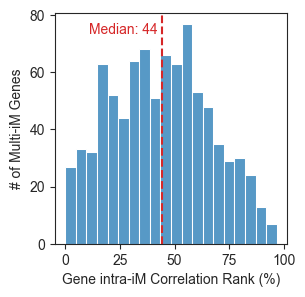

In [542]:
_, ax = plt.subplots(figsize=(3, 3))

sns.histplot(gene_in_im_corr_df.groupby('gene_id').median()['gene_corr_pct'], ax=ax, bins=20)
med = gene_in_im_corr_df.groupby('gene_id').median()['gene_corr_pct'].median()
ax.axvline(med, color='tab:red', linestyle='--')
ax.text(med * 0.96, 75, f"Median: {med:.0f}", ha='right', va='center', color='tab:red')

ax.set_xlabel('Gene intra-iM Correlation Rank (%)')
ax.set_ylabel('# of Multi-iM Genes')

plt.savefig(os.path.join(FIG_PATH, 'multi_gene_corr_rank.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'multi_gene_corr_rank.png'), dpi=400, bbox_inches='tight')

## bhsA Example

In [557]:
things = ica_data.M.columns[ica_data.M_binarized.loc['b1112'] == 1].to_list()
things

['Salicylic Acid',
 'Thiamine-2',
 'crp KO-1',
 'NtrC-2',
 'pts ALE',
 'FliA',
 'Hot TALE 16']

In [559]:
ica_data.A.T.corr(method='spearman').abs().loc[things, things]

,Salicylic Acid,Thiamine-2,crp KO-1,NtrC-2,pts ALE,FliA,Hot TALE 16
Salicylic Acid,1.000000,0.121838,0.400076,0.242115,0.271280,0.066821,0.435710
Thiamine-2,0.121838,1.000000,0.125160,0.146567,0.330674,0.155184,0.238011
crp KO-1,0.400076,0.125160,1.000000,0.287080,0.021439,0.088625,0.235576
NtrC-2,0.242115,0.146567,0.287080,1.000000,0.065389,0.133436,0.004262
pts ALE,0.271280,0.330674,0.021439,0.065389,1.000000,0.024430,0.354045
FliA,0.066821,0.155184,0.088625,0.133436,0.024430,1.000000,0.056628
Hot TALE 16,0.435710,0.238011,0.235576,0.004262,0.354045,0.056628,1.000000
